# Keras Neural Network implementation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate, StratifiedShuffleSplit
from tensorflow import keras
from tensorflow.keras import layers, metrics, callbacks
from keras.wrappers.scikit_learn import KerasClassifier 
import keras.backend as K
import sys
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam


# Project files

In [ ]:
sys.path.append('/content/drive/MyDrive/TFG/implementations/machine_learning_tfg/')
from src.utils.model_metrics_generator import ModelMetricsGenerator
from src.utils.cross_validation_utils import CrossValidationMetricsResultPrinter
from src.utils.my_metrics import accuracy_precision_recall_specifity_f2_score

# Data loading

In [ ]:
#input_data = pd.read_excel('/content/drive/MyDrive/TFG/notebooks/data/prepared/prepared_ICU_Prediction.xlsx')
input_data = pd.read_excel('/content/drive/MyDrive/TFG/implementations/machine_learning_tfg/data/prepared/prepared_ICU_Prediction.xlsx')
ground_truth = input_data['ICU']
sample_data = input_data.drop('ICU', axis=1)
train_data, test_data, train_truth, test_truth = train_test_split(sample_data, ground_truth, test_size=0.1, shuffle=True, random_state=42)

#splitting train set in subset_train and validation subsets
subset_train_data, validation_data, subset_train_truth, validation_truth = train_test_split(train_data, train_truth, test_size=0.1, shuffle=True, random_state=42)

num_features = train_data.shape[1]

# Functions

In [ ]:
def specificity(y_true, y_pred):    
  """ Function that implements specificity metric, its author is https://medium.com/@mostafa.m.ayoub/customize-your-keras-metrics-44ac2e2980bd

  """
  true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
  possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
  return true_negatives / (possible_negatives + K.epsilon())

def create_neural_network(layers, optimizer='adam', loss_function='binary_crossentropy', metrics=['accuracy', 'Recall', 'Precision', specificity]):
  """ Create a Keras neural network with the folloging attributes

  Arguments:
    layers: List of layers that will have the NN.Ensure  you pass them in the right oreder e.g: [first layer, ..., n hidden layers,..., lastlayer] 
          becuase they will be added in the same order.
  
    The other arguments are autoexplicatives.

  Returns:
    A Keras neural network model

  """
  
  model = keras.Sequential()
  
  for layer in layers:
    model.add(layer)

  model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics,
    )
  
  return model

def fit_neural_network(model, train_data, train_truth, validation_data, validation_truth, batch_size, epochs):
  """ Fit a keras NN with teh given arguments
  
  Returns: A Keras history object.
  """

  early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=2,
    restore_best_weights=True,
  )
  
  history = model.fit(
    train_data, train_truth,
    validation_data=(validation_data, validation_truth),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose = 0
    )
  
  return history


## Metrics functions

### Train and validation metrics values


In [ ]:
def print_neural_network_validation_metrics(history):
  history_df = pd.DataFrame(history.history)

  accuracy = round(get_val_accuracy(history_df) *100, 2)
  print(f'Accuracy: {accuracy}')

  precision = round(get_val_precision(history_df) *100, 2)
  print(f'Precision: {precision}')

  recall = round(get_val_recall(history_df) *100, 2)
  print(f'Recall: {recall}')

  specificity = round(get_val_specificity(history_df) *100, 2)
  print(f'Specifity: {specificity}')

  f2_score = round(get_val_fbeta_measure(history_df, 2) *100, 2)
  print(f'F2-score: {f2_score}')

  print('\n')
  print(accuracy)
  print(precision)
  print(recall)
  print(specificity)
  print(f2_score)

def get_val_accuracy(history):
  accuracy =  history['val_accuracy'].iloc[-1] 
  return accuracy

def get_val_recall(history):
  recall =  history['val_recall'].iloc[-1]
  return recall

def get_val_precision(history):
  precision =  history['val_precision'].iloc[-1]
  return precision

def get_val_specificity(history):
  specificity =  history['val_specificity'].iloc[-1]
  return specificity

def get_val_fbeta_measure(history, beta):
  row = history.iloc[-1]
  precision = row.val_precision
  recall = row.val_recall
  fbeta_score = (1+beta**2)*((precision * recall)/((beta**2 *precision)+recall))
  return fbeta_score

### Evaluation (predict) metrics

In [ ]:
def show_fit_plots(history):
  history_df = pd.DataFrame(history.history)
  fig, ax =plt.subplots(1,3)

  #loss
  sns.lineplot(data=history_df.loc[:, ['loss', 'val_loss']], ax=ax[0])
  ax[0].set(xlabel= 'Epochs', ylabel='Valor', title='Función de pérdida')

  #accuracy
  sns.lineplot(data=history_df.loc[:, ['accuracy', 'val_accuracy']], ax=ax[1])
  ax[1].set(xlabel= 'Epochs', title='Accuracy')

  #recall
  sns.lineplot(data=history_df.loc[:, ['recall', 'val_recall']], ax=ax[2])
  ax[2].set(xlabel= 'Epochs', title='Recall')

  fig.set_size_inches(14, 3)
  fig.show()


def print_metrics_values(results):
  accuracy = round(results[1] *100, 2)
  recall = round(results[2] * 100, 2)
  precision = round(results[3] * 100, 2)
  specifity_value = round(results[4]* 100, 2)
  f2_value = round(f2_score(precision, recall), 2)

  print(accuracy)
  print(recall)
  print(precision)
  print(specifity_value)
  print(f2_value)

def f2_score(precision, recall):
  return (1 +2**2)*((precision*recall)/((2**2 * precision) + recall))




## First approach to Keras Neural Network Models


CPU times: user 2.6 s, sys: 40.4 ms, total: 2.64 s
Wall time: 2.59 s
Accuracy: 79.03
Precision: 69.7
Recall: 58.97
Specifity: 88.24
F2-score: 60.85


79.03
69.7
58.97
88.24
60.85


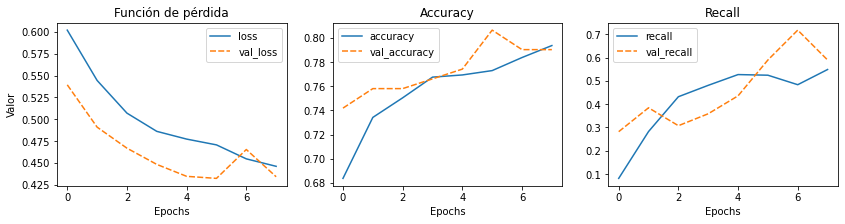

In [ ]:
#define hidden layers
neural_network_layers = [
                         layers.Dense(units=64, activation='relu'),
                         layers.Dense(units=1, activation='sigmoid')
                         ]

model = create_neural_network(layers=neural_network_layers)
%time history = fit_neural_network(model, train_data=subset_train_data, train_truth=subset_train_truth, validation_data=validation_data,\
                                   validation_truth=validation_truth, batch_size=128, epochs=10)

show_fit_plots(history)
print_neural_network_validation_metrics(history)


In [ ]:
results = model.evaluate(test_data, test_truth)
print_metrics_values(results)

5/5 [==============================] - 0s 3ms/step - loss: 0.4527 - accuracy: 0.7754 - recall: 0.4694 - precision: 0.8214 - specificity: 0.9528
77.54
46.94
82.14
95.28
51.34


CPU times: user 2.64 s, sys: 38 ms, total: 2.68 s
Wall time: 2.63 s


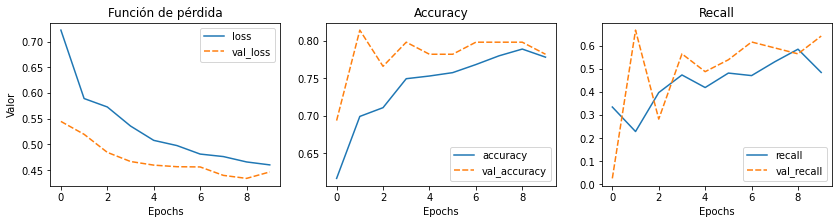

In [ ]:
#hidden layers
neural_network_layers2 = [
                         layers.Dense(units=64, activation='relu', input_dim=num_features),  
                         layers.Dropout(rate=0.3),
                         layers.Dense(units=1, activation='sigmoid')
                         ]

model2 = create_neural_network(layers=neural_network_layers2)
%time history2 = fit_neural_network(model2, train_data=subset_train_data, train_truth=subset_train_truth, validation_data=validation_data,\
                                   validation_truth=validation_truth, batch_size=128, epochs=10)

show_fit_plots(history2)

In [ ]:
results2 = model2.evaluate(test_data, test_truth)
print_metrics_values(results2)

5/5 [==============================] - 0s 3ms/step - loss: 0.4512 - accuracy: 0.7899 - recall: 0.6531 - precision: 0.7273 - specificity: 0.8844
78.99
65.31
72.73
88.44
66.67


CPU times: user 2.84 s, sys: 33.2 ms, total: 2.87 s
Wall time: 2.78 s


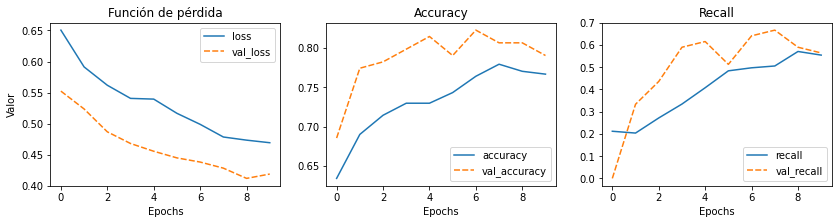

In [ ]:
#hidden layers
neural_network_layers3 = [
                         layers.Dense(units=64, activation='relu', input_dim=num_features),
                         layers.Dropout(rate=0.3),
                         layers.Dense(units=64, activation='relu'),
                         layers.Dropout(rate=0.3),
                         layers.Dense(units=1, activation='sigmoid')
                         ]
        
model3 = create_neural_network(layers=neural_network_layers3)
%time history3 = fit_neural_network(model3, train_data=subset_train_data, train_truth=subset_train_truth, validation_data=validation_data,\
                                   validation_truth=validation_truth, batch_size=128, epochs=10)

show_fit_plots(history3)

In [ ]:
results3 = model3.evaluate(test_data, test_truth)
print_metrics_values(results3)

5/5 [==============================] - 0s 3ms/step - loss: 0.4413 - accuracy: 0.7826 - recall: 0.4898 - precision: 0.8276 - specificity: 0.9535
78.26
48.98
82.76
95.35
53.33


CPU times: user 2.33 s, sys: 31.1 ms, total: 2.36 s
Wall time: 2.31 s


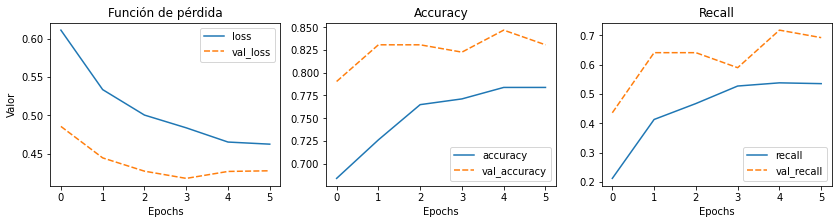

In [ ]:
#hidden layers
neural_network_layers4 = [
                         layers.Dense(units=128, activation='relu', input_dim=num_features),  
                         layers.Dropout(rate=0.3),
                         layers.Dense(units=1, activation='sigmoid')
                         ]

model4 = create_neural_network(layers=neural_network_layers4)
%time history4 = fit_neural_network(model4,train_data=subset_train_data, train_truth=subset_train_truth, validation_data=validation_data,\
                                   validation_truth=validation_truth, batch_size=128, epochs=10)

show_fit_plots(history4)

In [ ]:
results4 = model4.evaluate(test_data, test_truth)
print_metrics_values(results4)

5/5 [==============================] - 0s 3ms/step - loss: 0.4692 - accuracy: 0.7681 - recall: 0.4082 - precision: 0.8696 - specificity: 0.9715
76.81
40.82
86.96
97.15
45.67


# Grid search for hyperparameters optimization

@see https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def perform_grid_search(build_fn, param_grid, train_data, train_truth):
  
  model = KerasClassifier(build_fn=build_fn, verbose=0)
  sskfold = StratifiedShuffleSplit(random_state=1)
  scoring = accuracy_precision_recall_specifity_f2_score()
  grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=sskfold, scoring=scoring, refit='f2_score', n_jobs=-1)

  %time grid_result =  grid.fit(train_data, train_truth)
  return grid_result


def build_fn(num_features,neurons=1, layers_number=1):
  """ Create a keras neural network model for hyperparameters grid search

  """
  model = keras.Sequential([layers.Dense(units=neurons, activation='relu', input_dim=num_features)])
  for i in range(layers_number):
    model.add(layers.Dense(units=neurons, activation='relu', input_dim=num_features))
    model.add(layers.Dropout(0.3))
  model.add(layers.Dense(units=1, activation='sigmoid'))

  model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall']
    )
  
  return model

In [ ]:
# Hyperparaters values
neurons = [16, 32, 64, 128]
layers_number = [1, 2, 3, 4, 5]
batch_size = [64, 128, 256, 512]
epochs = [64, 256, 512, 768]
param_grid = dict(neurons=neurons,layers_number=layers_number, batch_size=batch_size, epochs=epochs, num_features = [num_features])

grid_model = perform_grid_search(build_fn, param_grid, train_data, train_truth)

#results
print(f'El mejor resultado :{grid_model.best_score_} se consigue con {grid_model.best_params_}')

#evaluate model against test data
model_metrics_generator = ModelMetricsGenerator(grid_model, test_truth)
model_metrics_generator.predict_model(test_data)
model_metrics_generator.print_results()